Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [53]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

In [54]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount = True)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

The file loaded into google drive is a zipped file, this needs to be unzipped first and saved into a new folder

In [55]:
#!unzip -q '/content/drive/MyDrive/CNN Assignment/CNN_assignment.zip' -d '/content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted'

In [56]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [57]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [58]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [59]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    batch_size = batch_size,
    seed = 123
)

Found 6739 files belonging to 9 classes.


In [60]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height,img_width),
    batch_size = batch_size,
    subset = "training",
    seed = 123,
    validation_split = 0.2
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [61]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

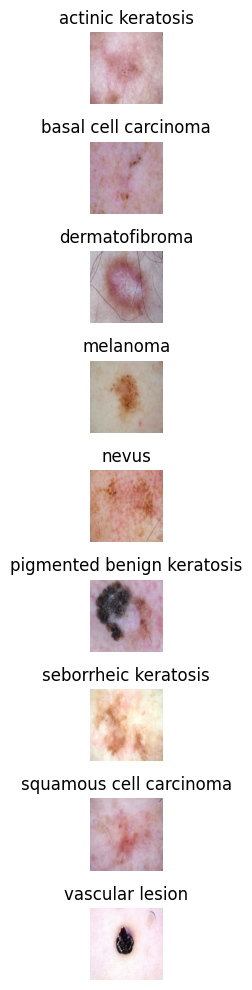

In [62]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
def plot_images_from_dataset(dataset, class_names, num_classes=9, images_per_class=1):
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(10, 10))
    axes = axes.flatten()

    class_counts = {class_name: 0 for class_name in class_names}
    plotted_images = {class_name: [] for class_name in class_names}

    for images, labels in dataset:
        for image, label in zip(images, labels):
            class_name = class_names[label]
            if class_counts[class_name] < images_per_class:
                idx = class_counts[class_name] * num_classes + class_names.index(class_name)
                axes[idx].imshow(image.numpy().astype("uint8"))
                axes[idx].set_title(class_name)
                axes[idx].axis('off')
                class_counts[class_name] += 1
                if all(count == images_per_class for count in class_counts.values()):
                    #break
                    plt.tight_layout()
                    plt.show()
                    return
        #if all(count == images_per_class for count in class_counts.values()):
            #break

    plt.tight_layout()
    plt.show()

# Plot images from the training dataset
plot_images_from_dataset(train_ds, class_names)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [63]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [64]:
### Your code goes here
model = Sequential(layers.experimental.preprocessing.Rescaling(scale = 1./255))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [65]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# View the summary of all layers
model.build((None, img_height, img_width, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_9 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 1013888)           0         
                                                                 
 dense_4 (Dense)             (None, 128)              

### Train the model

In [67]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
211/211 [==============================] - 88s 226ms/step - loss: 3.3843 - accuracy: 0.2422 - val_loss: 1.8931 - val_accuracy: 0.3279
Epoch 2/20
211/211 [==============================] - 18s 86ms/step - loss: 1.6437 - accuracy: 0.4017 - val_loss: 1.2303 - val_accuracy: 0.5406
Epoch 3/20
211/211 [==============================] - 18s 85ms/step - loss: 1.2962 - accuracy: 0.5409 - val_loss: 0.9827 - val_accuracy: 0.6801
Epoch 4/20
211/211 [==============================] - 18s 84ms/step - loss: 1.0168 - accuracy: 0.6519 - val_loss: 0.6736 - val_accuracy: 0.8027
Epoch 5/20
211/211 [==============================] - 18s 83ms/step - loss: 0.8247 - accuracy: 0.7341 - val_loss: 0.4404 - val_accuracy: 0.8869
Epoch 6/20
211/211 [==============================] - 18s 83ms/step - loss: 0.5949 - accuracy: 0.8218 - val_loss: 0.3348 - val_accuracy: 0.9234
Epoch 7/20
211/211 [==============================] - 18s 84ms/step - loss: 0.4873 - accuracy: 0.8610 - val_loss: 0.3161 - val_accuracy

### Visualizing training results

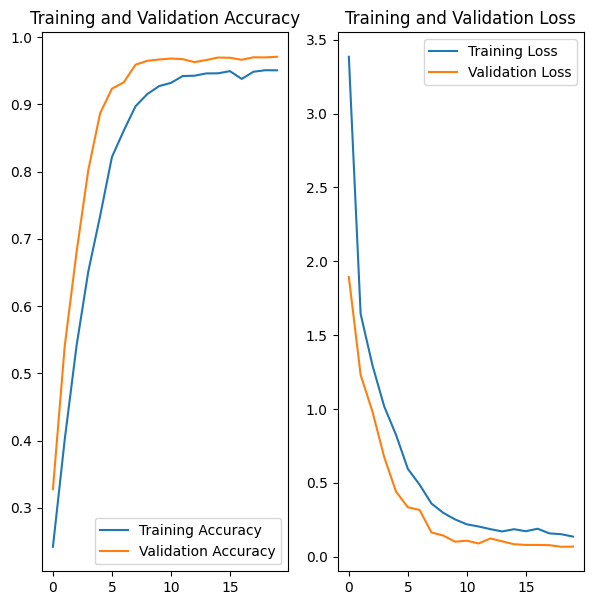

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7,7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model seems to be performing well with the training and validation data for the given number of epochs. As can be inferred from the chart above, the validation accuracy gradually increases as the number of epochs increase. This suggests the model is learning well with Backpropogation. Similarly, as can be inferred from the right chart, there is a knee bend around 2nd/3rd epoch suggesting a slow decrease in the training & validation loss.

### Write your findings here

In [69]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

In [70]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

### Todo:
### Create the model, compile and train the model


In [71]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here



### Compiling the model

In [72]:
## Your code goes here

### Training the model

In [73]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code

### Visualizing the results

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [74]:
## Your code goes here.
import collections

# Making use of the counter in collections that helps in counting the number of repetitions of an object in a list and store it in a dictionary
Imbalancecounter = collections.Counter()
for images,labels in train_ds:
  Imbalancecounter.update(labels.numpy())

for index, name in enumerate(class_names):
  print(f"{name}:{Imbalancecounter[index]} images")


actinic keratosis:614 images
basal cell carcinoma:876 images
dermatofibroma:595 images
melanoma:938 images
nevus:857 images
pigmented benign keratosis:962 images
seborrheic keratosis:577 images
squamous cell carcinoma:681 images
vascular lesion:639 images



#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Ans: seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### - Ans: pigmented benign keratosis dominates the data in terms of proportion of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [75]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [76]:
path_to_training_dataset="/content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E72B0541D20>: 100%|██████████| 500/500 [00:21<00:00, 23.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E726B91C880>: 100%|██████████| 500/500 [00:26<00:00, 18.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E72B0541D20>: 100%|██████████| 500/500 [00:19<00:00, 25.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E72B02F5F60>: 100%|██████████| 500/500 [01:37<00:00,  5.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E7240239300>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E726B9BEE00>: 100%|██████████| 500/500 [00:19<00:00, 25.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E724053E140>: 100%|██████████| 500/500 [00:41<00:00, 12.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E7240333520>: 100%|██████████| 500/500 [00:20<00:00, 24.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E726B9BCFA0>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [77]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [78]:
data_dir_train

PosixPath('/content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

### Lets see the distribution of augmented data after adding new images to the original training data.

In [79]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [80]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [81]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [82]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [83]:
#new_df['Label'].value_counts()
df2['Label'].value_counts()

Label
actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
melanoma                      1000
nevus                         1000
pigmented benign keratosis    1000
seborrheic keratosis          1000
squamous cell carcinoma       1000
vascular lesion               1000
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [84]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [85]:
data_dir_train="/content/drive/MyDrive/CNN Assignment/CNN_assignment_Extracted/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  #validation_split = 0.2,
  #subset = ## Todo choose the correct parameter value, so that only training data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.


4500 + 2239 = 6739 Files/Images found

#### **Todo:** Create a validation dataset

In [86]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create your model (make sure to include normalization)

In [87]:
## your code goes here
model = Sequential(layers.experimental.preprocessing.Rescaling(scale = 1./255))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180,180,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [88]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [89]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
352/352 [==============================] - 134s 374ms/step - loss: 2.8308 - accuracy: 0.2051 - val_loss: 2.0091 - val_accuracy: 0.2421
Epoch 2/30
352/352 [==============================] - 120s 338ms/step - loss: 1.7612 - accuracy: 0.3558 - val_loss: 1.4421 - val_accuracy: 0.4883
Epoch 3/30
352/352 [==============================] - 123s 348ms/step - loss: 1.5549 - accuracy: 0.4219 - val_loss: 1.2782 - val_accuracy: 0.5694
Epoch 4/30
352/352 [==============================] - 121s 342ms/step - loss: 1.2456 - accuracy: 0.5575 - val_loss: 0.9856 - val_accuracy: 0.6575
Epoch 5/30
352/352 [==============================] - 119s 335ms/step - loss: 0.9649 - accuracy: 0.6673 - val_loss: 0.6319 - val_accuracy: 0.7954
Epoch 6/30
352/352 [==============================] - 119s 336ms/step - loss: 0.7694 - accuracy: 0.7530 - val_loss: 0.4485 - val_accuracy: 0.8723
Epoch 7/30
352/352 [==============================] - 119s 335ms/step - loss: 0.5998 - accuracy: 0.8115 - val_loss: 0.3458 -

#### **Todo:**  Visualize the model results

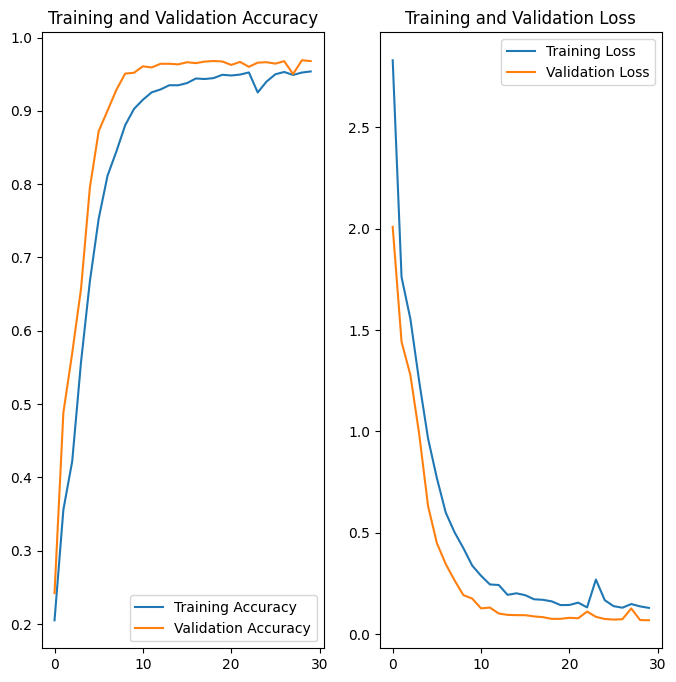

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The overfitting seems to have vanished. This is evident from the marginal decrease in the difference between training and validation accuracy as compared to the previous graph.